<h3 style="text-align:center;">LSTM for Bonn University Epilepsy Dataset</h3>
<table style="border-collapse: collapse;">
  <tr style="border: 1px solid #dddddd;">
    <th style="border: 1px solid #dddddd;">A </th>
    <th style="border: 1px solid #dddddd;">B</th>
    <th style="border: 1px solid #dddddd;">C</th>
    <th style="border: 1px solid #dddddd;">D</th>
    <th style="border: 1px solid #dddddd;">E</th>
  </tr>
    <tr style="border: 1px solid #dddddd;">
    <td style="border: 1px solid #dddddd;">Non-Epileptic</td>
    <td style="border: 1px solid #dddddd;">MNon-Epileptic</td>
    <td style="border: 1px solid #dddddd;">Epileptic</td>
    <td style="border: 1px solid #dddddd;">Epileptic</td>
    <td style="border: 1px solid #dddddd;">Epileptic</td>
   </tr>
   
  <tr style="border: 1px solid #dddddd;">
    <td style="border: 1px solid #dddddd;">Eyes Opened</td>
    <td style="border: 1px solid #dddddd;">Eyes Closed</td>
    <td style="border: 1px solid #dddddd;">Interictal</td>
    <td style="border: 1px solid #dddddd;">Interictal</td>
    <td style="border: 1px solid #dddddd;">Ictal</td>
   </tr>
</table>

# 1. Loading the data

Remarque: changer le chemin du dataset correspondante

In [3]:
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import os
from tqdm import tqdm

#tqdm library instantly make your loops show a smart progress bars.
#It gives "Code Execution Time" and Estimated Time for the code to complete
#This would help while working on huge datasets

DATA_DIR_A = r'/home/aya/EEG/Dataset/A/'
DATA_DIR_B = r'/home/aya/EEG/Dataset/B/'
DATA_DIR_C = r'/home/aya/EEG/Dataset/C/'
DATA_DIR_D = r'/home/aya/EEG/Dataset/D/'
DATA_DIR_E = r'/home/aya/EEG/Dataset/E/'
#changer le chemin du dataset correspondante
  
LABEL_C1 = 0
LABEL_C2 = 1
LABEL_C3 = 2

def load_data():
    data = []
    nbFiles = 0
    for fname in tqdm(os.listdir(DATA_DIR_A)):
        img = np.loadtxt(DATA_DIR_A + fname) #Load data from a text file and returns a numpy ndarray, it's a fast reader for simple text files. By default, the delimiter is a whitespace.
        data.append([np.array(img), np.array(LABEL_C1)]) 
        nbFiles+=1

    for fname in tqdm(os.listdir(DATA_DIR_B)):
        img = np.loadtxt(DATA_DIR_B + fname)
        data.append([np.array(img), np.array(LABEL_C1)])
        nbFiles+=1    
    
    for fname in tqdm(os.listdir(DATA_DIR_C)):
        img = np.loadtxt(DATA_DIR_C + fname)
        data.append([np.array(img), np.array(LABEL_C2)])
        nbFiles+=1

    for fname in tqdm(os.listdir(DATA_DIR_D)):
        img = np.loadtxt(DATA_DIR_D + fname)
        data.append([np.array(img), np.array(LABEL_C2)])
        nbFiles+=1

    for fname in tqdm(os.listdir(DATA_DIR_E)):
        img = np.loadtxt(DATA_DIR_E + fname)
        data.append([np.array(img), np.array(LABEL_C2)])
        nbFiles+=1
        
    return data


data = load_data()
print(len(data), "Files")#data is list of 500 arrays

100%|██████████| 100/100 [00:00<00:00, 1517.52it/s]

500 Files


<h2><font color="purple">Visualize the data</font></h2>

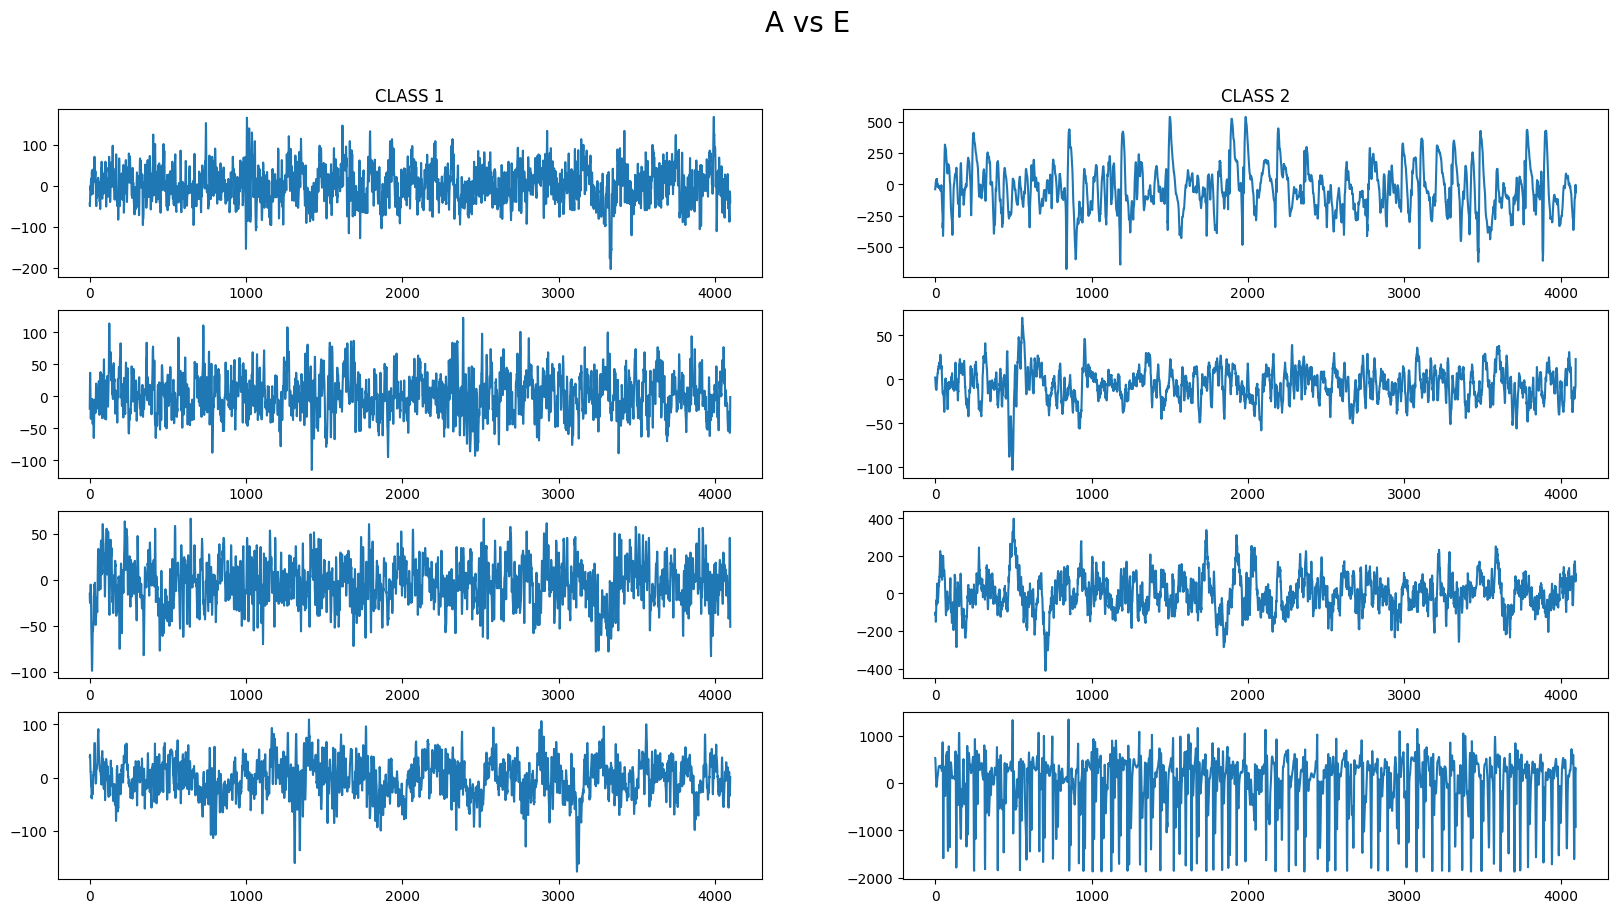

In [5]:
import random
mpl.rcParams['figure.figsize'] = (20,10)

fig = plt.figure()

samples_c1 = np.empty((0, 4097), int)
while len(samples_c1) < 4:
    curID = random.randint(0, len(data))
    if data[curID][1] == LABEL_C1:
        samples_c1 = np.vstack((samples_c1, data[curID][0]))
        
samples_c2 = np.empty((0, 4097), int)
while len(samples_c2) < 4:
    curID = random.randint(0, len(data))
    if data[curID][1] == LABEL_C2:
        samples_c2 = np.vstack((samples_c2, data[curID][0]))
        
for i in range(0, 4):
    plt.subplot(421 + i * 2)
    plt.plot(samples_c1[i])
    plt.subplot(421 + i * 2 + 1)
    plt.plot(samples_c2[i])

ax = plt.subplot(421)
ax.set_title("CLASS 1")
ax = plt.subplot(422)
ax.set_title("CLASS 2")

fig.suptitle("A vs E", fontsize=20)
plt.show()

The EEG signals produce a huge amount of redundant data, which highly affect the process of EEG analysis

In [7]:
data[0].notch_filter(np.arange(50, 251, 50))  

AttributeError: 'list' object has no attribute 'notch_filter'

# Prepare the data!

In [14]:
from sklearn.utils import shuffle
data = shuffle(data)

nb_train = round(len(data) * 0.8)
data_train = data[0:nb_train]
data_test = data[nb_train:]

X_train = np.array([d[0] for d in data_train])
Y_train = np.array([d[1] for d in data_train])

X_test = np.array([d[0] for d in data_test])
Y_test = np.array([d[1] for d in data_test])

X_train.shape
    
X_train = X_train.reshape(X_train.shape[0], 4097, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

X_test = X_test.reshape(X_test.shape[0], 4097, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM

#num_steps = 30
batch_size = 4
epochs = 20
hidden_size = 64
use_dropout=True

model = Sequential()
model.add(LSTM(hidden_size, input_shape=(4097,1)))
#model.add(LSTM(64, return_sequences=False))

if use_dropout:
  model.add(Dropout(0.35))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'acc'])

print(model.summary())

history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs)
score = model.evaluate(X_test, Y_test, batch_size=batch_size)

#checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)


# 1 LSTM with 64 (4097,1)
# Adam, Binary_CrossEntropy, Batch Size 4, Epoch 20
# --> 99 - 100% Accuracy (A <-> E)

2022-12-12 11:01:42.676217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 11:01:44.621814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-12 11:01:44.621898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-12 11:01:44.621907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
80/80 [==============================] - 63s 768ms/step - loss: 0.6912 - mae: 0.4630 - acc: 0.5938 - val_loss: 0.6569 - val_mae: 0.4774 - val_acc: 0.6375
Epoch 2/20
80/

dict_keys(['loss', 'mae', 'acc', 'val_loss', 'val_mae', 'val_acc'])


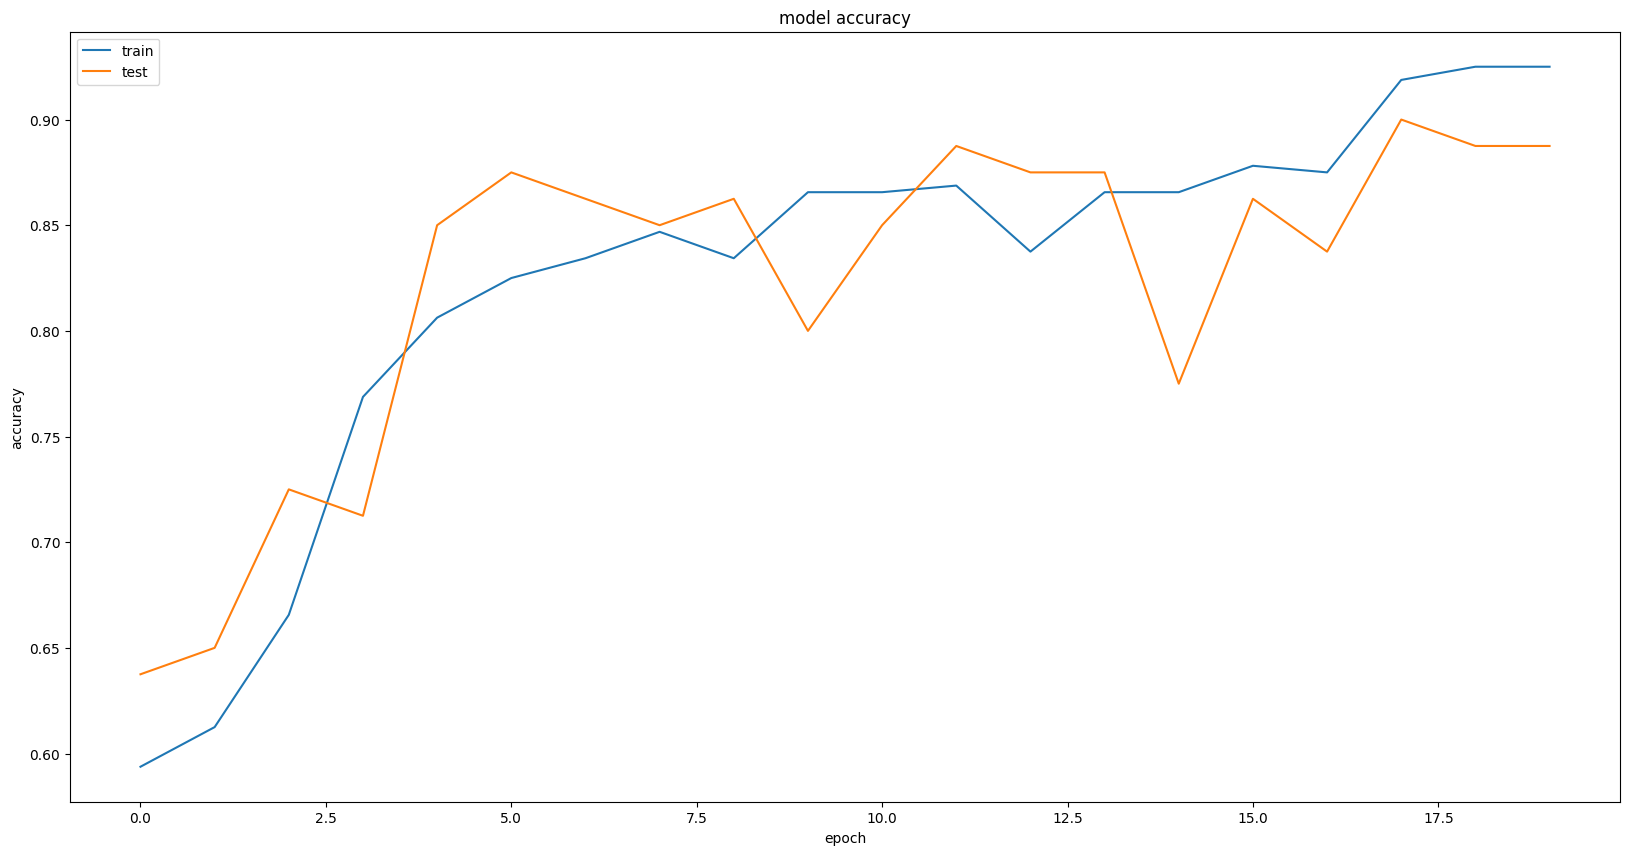

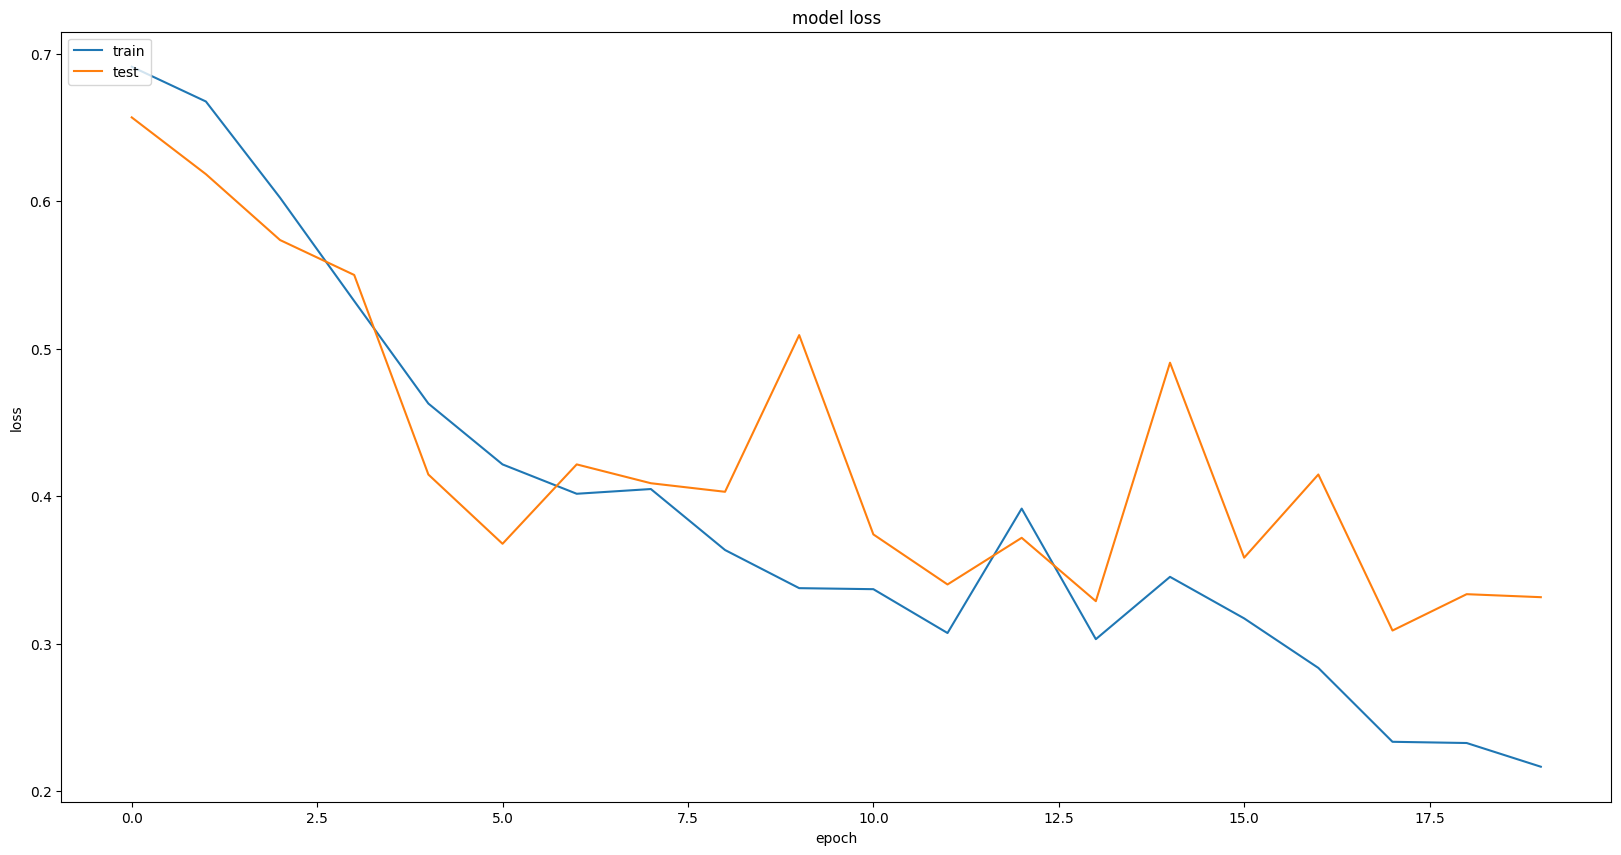

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 1. Data Preprocessing

# 2. Feature Extraction

In [22]:
import pywt
import pywt.data

# 3. Feature selection


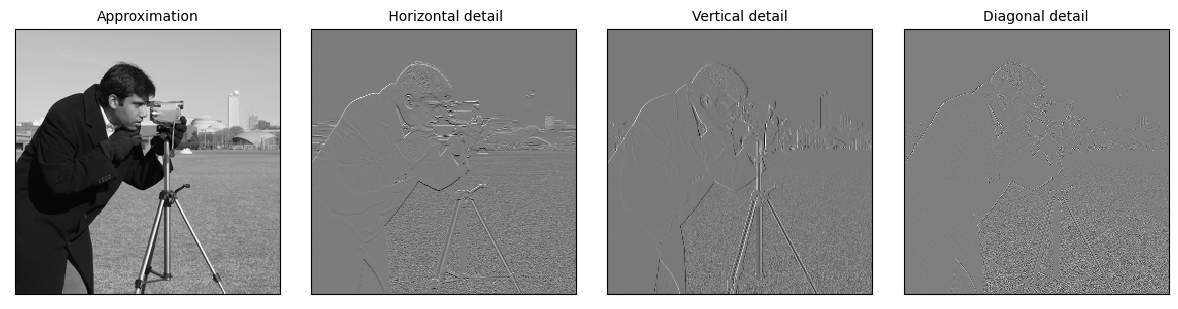

In [23]:
# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

# 4. classification